https://machinelearningmastery.com/lstm-autoencoders/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

1. MinMax scalar
2. Different loss functions
3. How to take output of encoder part

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=85e3a48b8157a91e23ef317550c660a2de31b48907bb452938bc4e337981d6b5
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=4db97f9cd4408067bde8b3aa160480ed8ea706f152f0f4280ffaa9fd4e45002c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
plt.rcParams["figure.figsize"] = [16,9]

In [4]:
col_names = ['timestamp (s)','subject_id', 'activityID', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
main_df = pd.read_csv('https://raw.githubusercontent.com/praveengadiyaram369/Human_Activity_Recognition/main/data/processed_data.csv',names=col_names)

In [5]:
main_df.head()

,timestamp (s),subject_id,activityID,X1,Y1,Z1,X2,Y2,Z2
0,37.66,101,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145
1,37.67,101,1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538
2,37.68,101,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831
3,37.69,101,1,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374
4,37.70,101,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582


In [6]:
main_df[['timestamp (s)','subject_id', 'activityID']].groupby(['subject_id', 'activityID']).agg(['count'])

timestamp (s)
                              count
subject_id activityID              
101        1                  27184
           2                  23471
           3                  21681
           4                  21602
           6                  23527
           7                  20173
           16                 22930
           17                 23553
102        1                  23429
           2                  22343
           3                  25572
           4                  31742
           6                  25107
           7                  28694
           16                 20681
           17                 28869
103        1                  22044
           2                  28761
           3                  20524
           4                  28570
           16                 20323
           17                 27966
104        1                  23045
           2                  25482
           3                  24683
           4                  30413
           6                  22699
           7                  26938
           16                 20031
           17                 24992

In [7]:
target_subjects = [101, 102, 104]
main_df = main_df.loc[main_df['subject_id'].isin(target_subjects)]

In [8]:
main_df.sort_values(by=['activityID'], inplace=True)
main_df[['timestamp (s)', 'activityID']].groupby(['activityID']).agg(['count'])

,timestamp (s)
,count
activityID,
1,73658
2,71296
3,71936
4,83757
6,71333
7,75805
16,63642
17,77414


In [9]:
drop_cols = ['timestamp (s)',	'subject_id']
main_df.drop(columns=drop_cols, axis=1, inplace=True)

In [10]:
main_df

,activityID,X1,Y1,Z1,X2,Y2,Z2
0,1,2.215300,8.279150,5.58753,-0.004750,0.037579,-0.011145
560657,1,5.793350,0.342883,8.01563,-0.000497,0.015359,-0.000944
560658,1,5.786670,0.341205,7.82310,0.032931,0.003406,-0.000893
560659,1,5.632040,0.227884,7.74419,0.024055,0.015242,-0.020681
560660,1,5.679450,0.457240,7.97505,0.038811,-0.040294,-0.012254
...,...,...,...,...,...,...,...
263167,17,-4.936810,4.137760,7.14932,-1.140110,0.871635,2.037300
263166,17,-5.091980,4.327280,6.99241,-1.202370,0.830822,2.022640
263165,17,-5.092790,4.781550,6.87540,-1.296120,0.803110,1.957850
263174,17,-3.866920,3.526590,7.62926,-1.347590,0.950134,2.044650


In [11]:
activities = set(list(main_df.activityID.unique()))
final_sensor_data = pd.DataFrame(columns=main_df.columns)
timesteps = 50
features = 6

for activity in activities:
  activity_df = main_df.loc[main_df['activityID'] == activity]
  
  extra_rows = len(activity_df.index)%timesteps
  timestep_rows = (len(activity_df.index) - extra_rows)

  if extra_rows > 0:
    activity_df = activity_df.iloc[:timestep_rows]

  final_sensor_data = pd.concat([final_sensor_data, activity_df])

In [12]:
activity_data = final_sensor_data.iloc[:, 0].values
sensor_data = final_sensor_data.iloc[:, 1:].values.astype('float32')
print(sensor_data.shape)

(588650, 6)


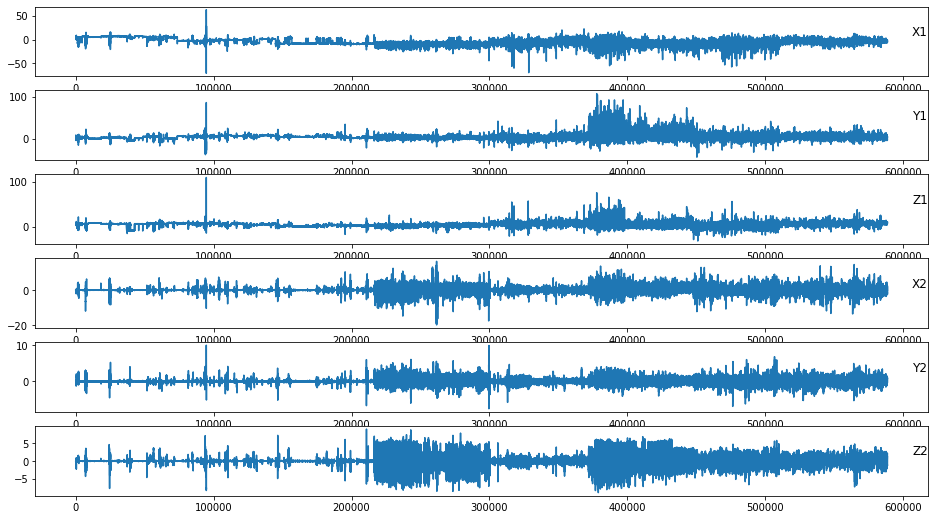

In [13]:
plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+3], y=0.5, loc='right')

plt.show()

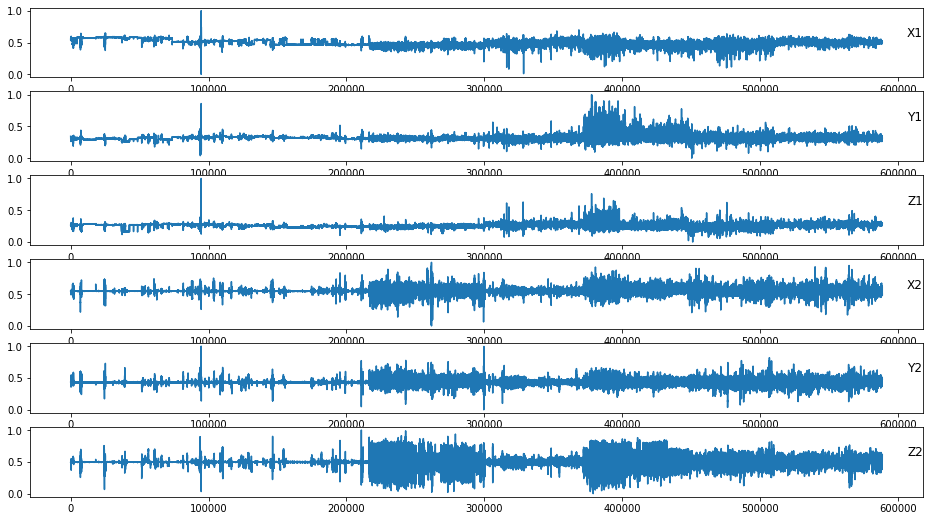

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for idx in range(features):
  sensor_data[:, idx] = MinMaxScaler().fit_transform(sensor_data[:, idx].reshape(-1, 1)).reshape(1,-1)

plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+3], y=0.5, loc='right')

plt.show()

In [15]:
sensor_data.shape

(588650, 6)

In [16]:
activity_data.shape

(588650,)

In [17]:
# _input data format - [samples, timesteps, features]
sensor_data = sensor_data.reshape(-1, timesteps, features)
sensor_data.shape

(11773, 50, 6)

In [18]:
# _input data format - [samples, timesteps, features]
activity_data = activity_data.reshape(-1, timesteps)
activity_data.shape

(11773, 50)

In [19]:
def build_model(hp):

    lstm_layer_1_output_params = hp.Int(
        'output_1', min_value=60, max_value=100, step=5)
    lstm_layer_2_output_params = hp.Int(
        'output_2', min_value=30, max_value=60, step=5)
    
    lstm_layer_1_dropoutrate_params = hp.Float(
        'dropoutrate_1', min_value=0.2, max_value=0.5, step=0.05)
    lstm_layer_2_dropoutrate_params = hp.Float(
        'dropoutrate_2', min_value=0.2, max_value=0.5, step=0.05)

    activation_fn_params = hp.Choice(
        'act_fn', values=['relu', 'tanh'])

    learning_rate_params = hp.Choice(
        'learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, input_shape=(timesteps, features), return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=False),
        tf.keras.layers.Dropout(rate=lstm_layer_1_dropoutrate_params),

        tf.keras.layers.RepeatVector(timesteps),

        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.Dropout(rate=lstm_layer_2_dropoutrate_params),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_params),loss='mae')

    return model

In [20]:
tuner_bo = kt.tuners.BayesianOptimization(
                build_model,objective=kt.Objective('val_loss', direction="min"), max_trials =20, executions_per_trial=2
)

tuner_bo.search(sensor_data, sensor_data, epochs=5, batch_size=64 ,validation_split=0.2)
best_model = tuner_bo.get_best_models(num_models=1)[0]
print(best_model.summary())

best_hp = tuner_bo.get_best_hyperparameters()[0]
print(best_hp.values)

Trial 20 Complete [00h 00m 33s]
val_loss: 0.02516085095703602

Best val_loss So Far: 0.02516085095703602
Total elapsed time: 01h 06m 56s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 60)            29040     
_________________________________________________________________
lstm_3 (LSTM)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

history = best_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

Epoch 1/50
221/221 [==============================] - 9s 21ms/step - loss: 0.0236 - val_loss: 0.0281
Epoch 2/50
221/221 [==============================] - 3s 15ms/step - loss: 0.0202 - val_loss: 0.0276
Epoch 3/50
221/221 [==============================] - 4s 16ms/step - loss: 0.0180 - val_loss: 0.0272
Epoch 4/50
221/221 [==============================] - 4s 16ms/step - loss: 0.0167 - val_loss: 0.0269
Epoch 5/50
221/221 [==============================] - 3s 15ms/step - loss: 0.0157 - val_loss: 0.0266
Epoch 6/50
221/221 [==============================] - 4s 17ms/step - loss: 0.0154 - val_loss: 0.0263
Epoch 7/50
221/221 [==============================] - 3s 16ms/step - loss: 0.0149 - val_loss: 0.0265
Epoch 8/50
221/221 [==============================] - 4s 16ms/step - loss: 0.0149 - val_loss: 0.0265
Epoch 9/50
221/221 [==============================] - 4s 16ms/step - loss: 0.0143 - val_loss: 0.0262


In [22]:
# lstm_ae_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(50, activation='relu', input_shape=(timesteps, features), return_sequences=True),
#     tf.keras.layers.LSTM(25, activation='relu', return_sequences=False),
#     tf.keras.layers.Dropout(rate=0.2),

#     tf.keras.layers.RepeatVector(timesteps),

#     tf.keras.layers.LSTM(25, activation='relu', return_sequences=True),
#     tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
#     tf.keras.layers.Dropout(rate=0.2),

#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
# ])
# lstm_ae_model.compile(optimizer='adam', loss='mae')
# lstm_ae_model.summary()

In [23]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     min_delta=0.001, 
#     patience=5, 
#     restore_best_weights=True,
# )

# history = lstm_ae_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

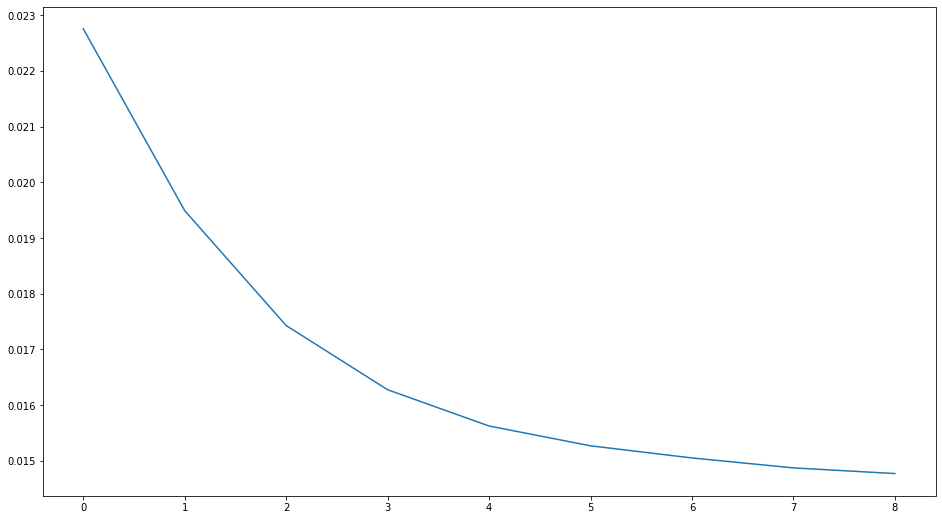

In [24]:
plt.plot(history.history['loss'])
plt.show()

In [26]:
get_3rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[2].output])
encoder_output = get_3rd_layer_output(sensor_data)
sensor_features = np.asarray(encoder_output).astype('float32')
sensor_features = sensor_features.reshape(sensor_features.shape[1], sensor_features.shape[2])
sensor_features.shape

(11773, 60)

In [27]:
activity_data.shape

(11773, 50)

In [28]:
activity_data = activity_data[:, 0]
activity_data = activity_data.reshape(-1, 1).astype('int32')
activity_data.shape

(11773, 1)

In [29]:
final_data = np.append(activity_data, sensor_features, axis=1)
final_data.shape

(11773, 61)

In [30]:
np.savetxt("sensor_features_lstm_tuned.csv", final_data, delimiter=",")